# Summary
*Note: In all cases, the number of notifications is per month, and the percentages are out of the total number of users who received any notifications, or the total number of notifications received.*

The distribution of notifications seems largely to follow a long-tailed [power law](https://en.wikipedia.org/wiki/Power_law) distribution. Almost all users receive very few (about 94% get from 1 to 4), while a very small number of highly-active users account for a large number of notifications (with 1-2% of users receiving 25 or more per month, and about 0.1% receiving 10-15% of the total notifications). 

The wikis I studied fell into three main groups:
* English Wikipedia and Japanese Wikipedia, which I expect represent "normal" large wikis. 
* Commons, where the number of highly-notified users is particularly small (98.5% of users receive 1 to 4 notifications, and 0.1% receive 25 or more). 
* French Wikipedia and Chinese Wikipedia, where Flow is used heavily. Both these wikis have a somewhat larger proportion of users with many notifications, largely because of substantial bump in the proportion of users with who get 20–30 notifications per month.

I would suggest the following conclusions based on this data:
* It is not worth investing significant resources into notification management tools (other than better bundling) until Flow or similar products are rolled out to more wikis.
* It may be worth investigating the small subset of users who receive a very high number of notifications to learn more about their habits. For example, they may be bots, or as highly-active users they may feel that they badly need better notification management.

# Data collection
## Choice of wikis ##
I chose to look at notification use on five different wikis:
* Commons (commonswiki)
* English Wikipedia (enwiki)
* Japanese Wikipedia (jawiki), 
* French Wikipedia (frwiki)
* Chinese Wikipedia (zhwiki).

Commons, enwiki, and jawiki represent "normal" large wikis; on the other hand, frwiki and zhwiki are relatively heavy users of [Flow](https://www.mediawiki.org/wiki/Flow) (frwiki at its central discussion board and zhwiki on user talk pages). Flow generates a large number of notifications but is not in use at many wikis; in making heavy use of notifications, it represents the likely future direction of MediaWiki software.

## SQL ##
The data was generated from the [Echo extension's](https://www.mediawiki.org/wiki/Notifications) database tables using the following queries:

**Total notifications**
```
SELECT 
	DATABASE() as "wiki",
	`notifications`,
	 COUNT(*) as "users"
FROM
(
	SELECT
		COUNT(*) as "notifications"
	FROM echo_notification
	WHERE
		notification_timestamp > "20160111" AND
		notification_timestamp < "20160210" AND
        notification_bundle_base = 1
	GROUP BY notification_user
) notifications_by_user
GROUP BY `notifications`;
```

**Unread notifications**
```
SELECT
	DATABASE() as "wiki",
	`unread notifications`,
	 COUNT(*) as "users"
FROM
(
	SELECT
		SUM( IF( notification_read_timestamp IS NULL, 1, 0) ) as "unread notifications"
	FROM echo_notification
	WHERE
		notification_timestamp > "20160111" AND
		notification_timestamp < "20160210" AND
        notification_bundle_base = 1
	GROUP BY notification_user
) notifications_by_user
GROUP BY `unread notifications`;
```
I gathered the results from the 5 different wikis using [multiquery](https://github.com/halfak/multiquery) with the following command:

```
$ multiquery {{sql file}} --dbnames=notifications_dbs.tsv --host=x1-analytics-slave.eqiad.wmnet --defaults-file=~/.my.cnf > {{output file}}
```

I ran the unread query on 23 March, so the unread counts reflect notifications from the month which were still unread 40 days after it ended. Therefore, those counts likely reflect notifications which can be considered permanently unread.

## Notification bundling ##
The queries which follow include `notification_bundle_base = 1` to exclude "bundled" notifications, which (1) don't behave as a standalone notifications from the user's point of view and (2) are never directly marked as read in the database (instead their read status is computed 

There are downsides to this approach. The bundled notifications are real notifications (although they're generally less interesting to the user than stand-alone notifications), and omitting them will undercount notification activity. However, the largest purpose of this study is to understand whether users are currently overloaded with notifications, and bundling is an effective toal for reducing that load. In addition, the number of *unread* notifications is an important part of this study, and the logic used to determine whether a bundled notification has been read is far too complex to reimplement her.

This change dramatically affects the results relating to unread notifications; a [previous version](https://github.com/neilpquinn/2016-02-notifications-exploration/blob/8d2bfbd848afe22a1dc178ad1abfc760a6673352/Notifications%20research.ipynb) of this study found that, for example, 19% of enwiki users with at least 25 notifications had at least 25 *unread* notifications. By excluding bundled notifications, that figures goes down to 2%.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax

%matplotlib inline

In [3]:
notifs = pd.read_table("./notifications_per_user.tsv")
unreads = pd.read_table("./unread_notifications_per_user.tsv")
wikis = set(notifs["wiki"])

notifs.tail()

,wiki,notifications,users
580,zhwiki,168,1
581,zhwiki,182,1
582,zhwiki,231,1
583,zhwiki,264,1
584,zhwiki,378,1


In [4]:
def filter_by_wiki( df, wiki ):
    return df[ df["wiki"] == wiki ].iloc[:, 1:3]

def plot_by_wiki( df, wiki, range = (5, 104), bins = 20, ax = plt ): 
    dist = filter_by_wiki( df, wiki )
    ax.hist( dist.iloc[:, 0], bins = bins, range = range, weights = dist.iloc[:, 1])
    ax.set_title(wiki)
    ax.set_xlabel( "Number of notifications" )
    ax.set_ylabel( "Users" )

# Total notifications

This data covers all the users who received at least one notification during the month, whether they actually visited the site during month or not, so we'd expect that the numbers are dominated by a large bulk of users with very few notifications, and that there's a long tail of very few users with a very large number of notifications. 

But let's characterize that a bit. At each wiki, how many and what percent of users with any notifications got fewer than 5?

In [70]:
def beyond_threshold(df, wikis, threshold, direction):
    columns = [
    "wiki",
    "users",
    "% of users",
    "% of notifications"
    ]
    
    results = []
    
    for wiki in wikis:
        by_wiki = filter_by_wiki(df, wiki)
        total_users = by_wiki.iloc[:, 1].sum()
        
        total_notifs = 0 
        for row in by_wiki.iterrows():
            total_notifs += row[1][0] * row[1][1]
        
        if direction == "under":
            beyond_threshold = by_wiki[ by_wiki.iloc[:, 0] < threshold ]
        elif direction == "over":
            beyond_threshold = by_wiki[ by_wiki.iloc[:, 0] > threshold ]
        
        users_beyond_threshold = beyond_threshold.iloc[:, 1].sum()
        notifs_beyond_threshold = 0
                
        for row in beyond_threshold.iterrows():
            notifs_beyond_threshold += row[1][0] * row[1][1]
        
        user_proportion = users_beyond_threshold / total_users
        notifs_proportion = notifs_beyond_threshold / total_notifs
        
        results.append([
            wiki, 
            users_beyond_threshold,
            round(user_proportion * 100, 1),
            round(notifs_proportion * 100, 1)
        ])
    
    results = pd.DataFrame(results, columns=columns)
    return results

beyond_threshold( notifs, wikis, 5, "under")

,wiki,users,% of users,% of notifications
0,frwiki,30750,95.9,60.9
1,jawiki,8643,95.0,63.7
2,enwiki,221595,96.1,62.4
3,zhwiki,8642,96.2,57.3
4,commonswiki,106027,99.4,90.6


And what percent of users got 30 notifications or more—becoming "daily notified"?

In [71]:
beyond_threshold(notifs, wikis, 29, "over")  

,wiki,users,% of users,% of notifications
0,frwiki,297,0.9,26.2
1,jawiki,45,0.5,15.7
2,enwiki,1196,0.5,20.9
3,zhwiki,68,0.8,27.1
4,commonswiki,91,0.1,5.6


That's lower than I expected at English Wikipedia. It only had about 1500 users with at least 25 notifications per month, compared to 30,000 active and 3,500 highly active users per month. However, both Flow wikis have higher percentages than the non-Flow wikis.

Now, let's look at the actual distributions. To make it easier to comprehend, I'll cut off the 90%+ of users with fewer than 5 notifications. I'll also cut off the users with 100 or more. How many is that?

In [72]:
beyond_threshold(notifs, wikis, 99, "over")

,wiki,users,% of users,% of notifications
0,frwiki,57,0.2,11.2
1,jawiki,6,0.1,6.5
2,enwiki,251,0.1,10.0
3,zhwiki,9,0.1,9.9
4,commonswiki,19,0.0,2.8


Now for the graphs:

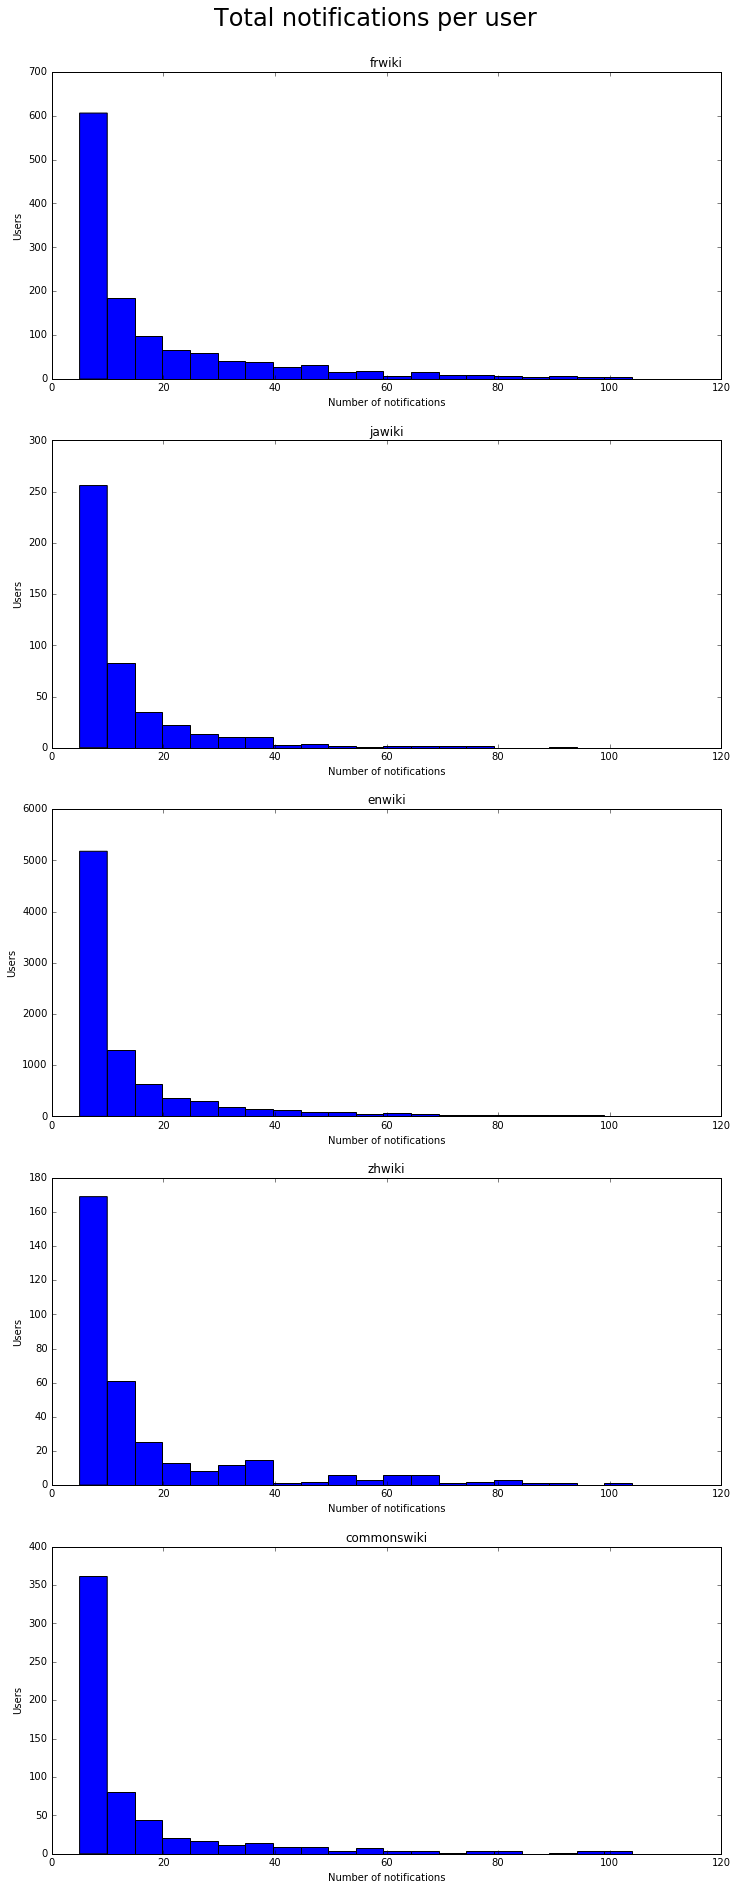

In [8]:
fig, axarr = plt.subplots( 5, 1, figsize=(12,30) )
fig.suptitle("Total notifications per user", fontsize=24)
fig.subplots_adjust(top=0.95)
i = 0
for wiki in wikis:
    plot_by_wiki(notifs, wiki, ax = axarr[i])
    i = i + 1

So, as expected, all the wikis have a pretty regular [power-law distribution](https://en.wikipedia.org/wiki/Power_law) of notifications. 

# Unread notifications

First, the counts and percentages for various levels of unread notifications.

Under 5:

In [73]:
beyond_threshold(unreads, wikis, 5, "under")

,wiki,users,% of users,% of notifications
0,frwiki,32009,99.8,97.3
1,jawiki,9068,99.7,95.1
2,enwiki,230200,99.9,96.1
3,zhwiki,8967,99.8,95.1
4,commonswiki,106625,100.0,98.9


30 or more (daily notified):

In [74]:
beyond_threshold(unreads, wikis, 29, "over")

,wiki,users,% of users,% of notifications
0,frwiki,7,0.0,1.4
1,jawiki,1,0.0,0.8
2,enwiki,26,0.0,2.2
3,zhwiki,1,0.0,1.4
4,commonswiki,3,0.0,1.0


100 or more:

In [75]:
beyond_threshold(unreads, wikis, 99, "over")

,wiki,users,% of users,% of notifications
0,frwiki,1,0.0,0.5
1,jawiki,0,0.0,0.0
2,enwiki,9,0.0,1.6
3,zhwiki,0,0.0,0.0
4,commonswiki,3,0.0,1.0


Now, the graphs:

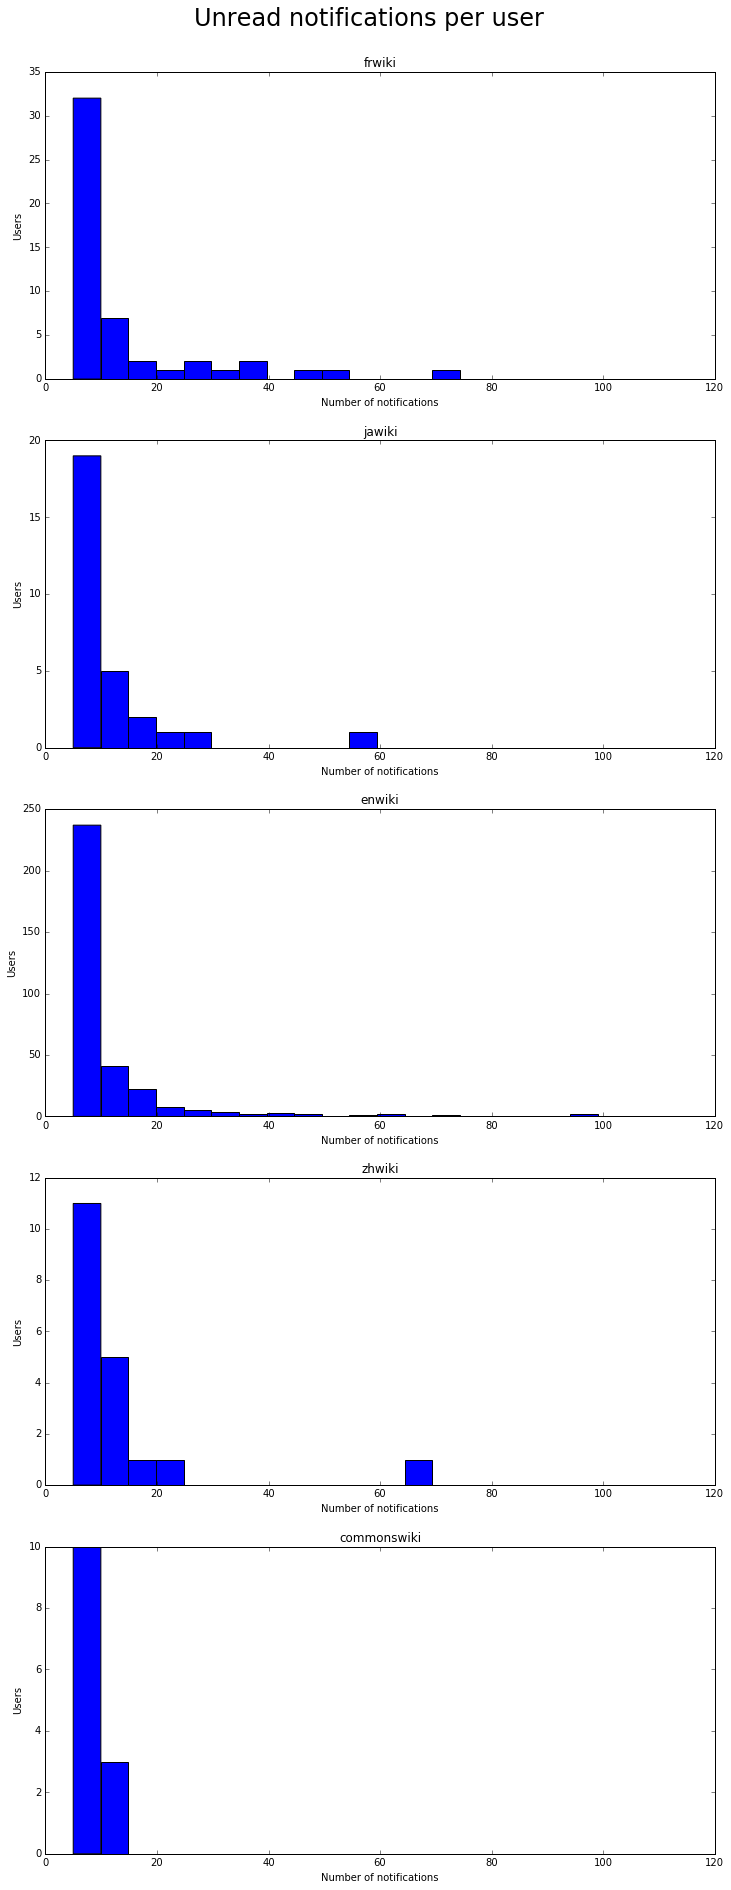

In [12]:
fig, axarr = plt.subplots( 5, 1, figsize=(12,30) )
fig.suptitle("Unread notifications per user", fontsize=24)
fig.subplots_adjust(top=0.95)
i = 0
for wiki in wikis:
    plot_by_wiki(unreads, wiki, ax = axarr[i])
    i = i + 1